In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
import pandas as pd

# ✅ Update this path if your folder name is different
data_path = '/content/drive/MyDrive/UTKFace/'

# Get all image file names
image_files = [f for f in os.listdir(data_path) if f.endswith('.jpg')]

# List to hold data
data = []

# Parse filenames and apply logic
for idx, file in enumerate(image_files):
    try:
        age, gender, _, _ = file.split('_')
        age = int(age)
        gender = int(gender)

        # Simulated hair length (alternating)
        hair_length = 'long' if idx % 2 == 0 else 'short'

        # Apply rule: override gender between age 20–30
        if 20 <= age <= 30:
            if hair_length == 'long':
                target_gender = 1  # female
            else:
                target_gender = 0  # male
        else:
            target_gender = gender  # use actual gender

        # Save record
        data.append({
            'image_path': os.path.join(data_path, file),
            'age': age,
            'gender': gender,
            'hair_length': hair_length,
            'target_gender': target_gender
        })
    except:
        continue


In [5]:
df = pd.DataFrame(data)
df.head()


,image_path,age,gender,hair_length,target_gender
0,/content/drive/MyDrive/UTKFace/32_0_0_20170116...,32,0,long,0
1,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31,1,short,1
2,/content/drive/MyDrive/UTKFace/31_1_4_20170103...,31,1,long,1
3,/content/drive/MyDrive/UTKFace/31_1_3_20170119...,31,1,short,1
4,/content/drive/MyDrive/UTKFace/31_1_3_20170117...,31,1,long,1


In [6]:
# Optional: Save for debugging
df.to_csv('/content/drive/MyDrive/processed_utkface.csv', index=False)


In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['target_gender'], random_state=42)

print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)


Training set size: (10087, 5)
Validation set size: (2522, 5)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE   = (128, 128)
BATCH_SIZE = 32

# 🔑 convert labels to string so 'binary' mode accepts them
train_df['target_gender'] = train_df['target_gender'].astype(str)
val_df['target_gender']   = val_df['target_gender'].astype(str)

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='target_gender',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='target_gender',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10087 validated image filenames belonging to 2 classes.
Found 2522 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models, callbacks

# Build CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
ckpt = callbacks.ModelCheckpoint('saved_model.h5', monitor='val_accuracy', save_best_only=True)
early = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[ckpt, early]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5019 - loss: 0.6975

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


316/316 ━━━━━━━━━━━━━━━━━━━━ 3665s 12s/step - accuracy: 0.5019 - loss: 0.6975 - val_accuracy: 0.5266 - val_loss: 0.6915
Epoch 2/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.5486 - loss: 0.6892

316/316 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.5486 - loss: 0.6892 - val_accuracy: 0.5393 - val_loss: 0.6915
Epoch 3/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.5662 - loss: 0.6855

316/316 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.5661 - loss: 0.6855 - val_accuracy: 0.5464 - val_loss: 0.6891
Epoch 4/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.5646 - loss: 0.6812

316/316 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.5646 - loss: 0.6812 - val_accuracy: 0.5523 - val_loss: 0.6897
Epoch 5/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.5738 - loss: 0.6754 - val_accuracy: 0.5492 - val_loss: 0.6981
Epoch 6/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5918 - loss: 0.6684

316/316 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.5918 - loss: 0.6684 - val_accuracy: 0.5531 - val_loss: 0.6889
Epoch 7/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.6068 - loss: 0.6601

316/316 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.6068 - loss: 0.6601 - val_accuracy: 0.5591 - val_loss: 0.7194
Epoch 8/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.6267 - loss: 0.6430 - val_accuracy: 0.5555 - val_loss: 0.6993
Epoch 9/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.6515 - loss: 0.6207 - val_accuracy: 0.5416 - val_loss: 0.7207
Epoch 10/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.6845 - loss: 0.5827

316/316 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.6845 - loss: 0.5827 - val_accuracy: 0.5595 - val_loss: 0.7242
Epoch 11/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.7063 - loss: 0.5526 - val_accuracy: 0.5539 - val_loss: 0.7636
Epoch 12/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7426 - loss: 0.4941 - val_accuracy: 0.5511 - val_loss: 0.8410
Epoch 13/15
251/316 ━━━━━━━━━━━━━━━━━━━━ 1:04 991ms/step - accuracy: 0.7885 - loss: 0.4349

79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 366ms/step
Classification Report:
              precision    recall  f1-score   support

        Male      0.568     0.532     0.549      1273
      Female      0.552     0.588     0.569      1249

    accuracy                          0.559      2522
   macro avg      0.560     0.560     0.559      2522
weighted avg      0.560     0.559     0.559      2522



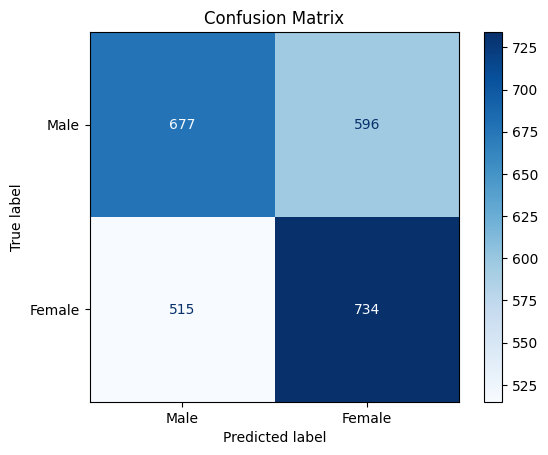

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


val_gen.reset()


y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)


y_true = val_df['target_gender'].astype(int).values


print("Classification Report:")
print(classification_report(y_true, y_pred, digits=3,
                            target_names=['Male', 'Female']))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Male', 'Female'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
